#Task
- change units in encoding and decoding layer from 10-500 in 12 steps
- change units in bottle neck layer from 5-100 in 8 steps
- train on minibatches of the whole data set without dataloaders
- single line progress report using sys

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-720ca452c718>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

In [ ]:
dataT.shape

torch.Size([20000, 784])

In [ ]:
# create a class for the model
def createTheMNISTAE(en_unit, bot_unit):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,en_unit)

      ### encoder layer
      self.enc = nn.Linear(en_unit,bot_unit)

      ### latent layer
      self.lat = nn.Linear(bot_unit,en_unit)

      ### decoder layer
      self.dec = nn.Linear(en_unit,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

##test to make sure this works


In [ ]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE(500,100)

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


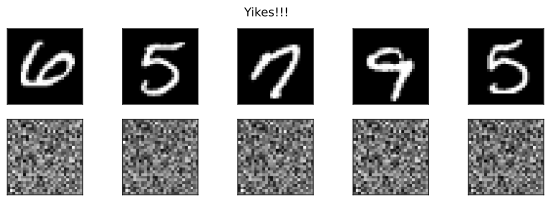

In [ ]:
# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Yikes!!!')
plt.show()

In [ ]:
np.random.permutation(dataT.shape[0]).astype(int)


array([ 7565,  1086,  8578, ..., 19524,  9484, 19700])

In [ ]:
def function2trainTheModel(encoder_units, bottleNeck_units):

  # number of epochs
  numepochs = 3

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE(encoder_units,bottleNeck_units)

  # initialize losses
  losses = torch.zeros(numepochs)
  batch_size = 32
  num_batches = dataT.shape[0] // batch_size # number of data samples/selected batch size

  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.permutation(dataT.shape[0]).astype(int) #vector of random integers
    batchLosses = []

    for batch in range(num_batches):
      samples2use = range((batch-1)*batch_size, batch*batch_size) # non overlapping blocks of the samples


      X = dataT[randomidx[samples2use],:] # select the images

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLosses.append(loss.item())
      # losses in this epoch
    losses[epochi] = np.mean(batchLosses[-3:])
  # end epochs

  # function output
  return losses,net

In [ ]:
# testing the function
# batchLoss,_ = function2trainTheModel(10, 5)


In [ ]:
# plt.plot(batchLoss)
# plt.show()

In [ ]:
# train the model (90s)
encoderUnits = np.linspace(10,500,12).astype(int)
bottleNeckUnits = np.linspace(5,100,8).astype(int)
losses = np.zeros((len(encoderUnits,), len(bottleNeckUnits)))
counter = 1
for i, enUnit in enumerate(encoderUnits):
  for j, bUnit in enumerate(bottleNeckUnits):
    batchLoss,_ = function2trainTheModel(enUnit, bUnit)
    losses[i][j] = torch.mean(batchLoss[-3:]).item()
    sys.stdout.write(f"\rProgress: {counter} / {len(encoderUnits)*len(bottleNeckUnits)}") #\r refreshes the line. deletes the rewrites
    counter +=1


Progress: 96 / 96

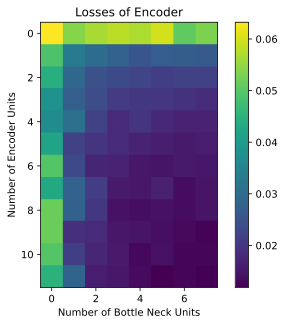

In [ ]:
plt.imshow(losses, cmap='viridis', interpolation='nearest')

# Add a color bar to the right of the heat map
plt.colorbar()

# Add labels and title
plt.xlabel('Number of Bottle Neck Units')
plt.ylabel('Number of Encoder Units')
plt.title('Losses of Encoder')

# Display the plot
plt.show()

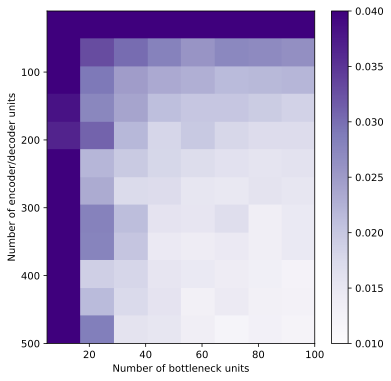

In [ ]:
# show the results matrix
fig = plt.figure(figsize=(6,6))

plt.imshow(losses,aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.04, cmap='Purples', # color range and palette
           extent=[ bottleNeckUnits[0],bottleNeckUnits[-1],encoderUnits[-1],encoderUnits[0], ]) # xy axis ticks


plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

- bottom right shows there is less compression b/c there are lots of units
- more units gives better performance but that might not be the total goal
- however we do want the units in the inner most layer to be of low dimensionality
- all depends what you want to do
- it is a trade of of size vs performance
- CNN base AE then the choice is easier b/c the model performs better with fewer parameters

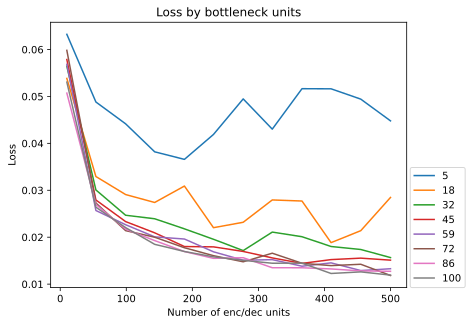

In [ ]:
# perhaps a line plot will better reveal the sudden transition

plt.plot(encoderUnits,losses)
plt.legend(bottleNeckUnits,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()

- just another way to look at the same data